## Taxi 데이터를 통해 전반적인 Workflow
- Data lake -> Data Warehouse -> Data Mart -> 시각화

In [108]:
import findspark
findspark.init()

In [109]:
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("trip_count_sql").getOrCreate()

In [110]:
directory='c://Users//apfhd//SparkExam//data//'
trip_files="//trips//*"
zone_file="taxi+_zone_lookup.csv"

In [111]:
trips_df=spark.read.csv(f'file:///{directory}//{trip_files}',inferSchema=True,header=True)
zone_df=spark.read.csv(f'file:///{directory}//{zone_file}', inferSchema=True, header=True)

In [112]:
trips_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [113]:
zone_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [114]:
trips_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2021-01-01 00:30:10|  2021-01-01 00:36:12|              1|          2.1|         1|                 N|         142|          43|           2|        8.0|  3.0|    0.5|       0.0|         0.0|                  0.3

In [115]:
zone_df.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



In [116]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

### DataLake => ``Data Warehouse``
- trips_df, zone_df를 합친 새로운 DataFrame 만들어 주기 (Warehouse)

In [117]:
query="""
select 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    To_dATE(t.tpep_dropoff_datetime) as dropoff_date,
    HoUR(t.tpep_pickup_datetime) as pickup_time,
    HoUR(t.tpep_dropoff_datetime) as dropoff_time,
    
 

    pz.zone as pickup_zone

from trips t
left join zone pz on t.PULocationID = pz.LocationID


"""
spark.sql(query).show(5)
#   dz.zone as dropoff_zone
#left join zone dz on t.PULocationID = dz.LocationID

+---------+-----------+------------+-----------+------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|         pickup_zone|
+---------+-----------+------------+-----------+------------+--------------------+
|        1| 2021-01-01|  2021-01-01|          0|           0| Lincoln Square East|
|        1| 2021-01-01|  2021-01-01|          0|           0|Upper West Side N...|
|        1| 2021-01-01|  2021-01-01|          0|           1|         JFK Airport|
|        1| 2021-01-01|  2021-01-01|          0|           0|   LaGuardia Airport|
|        2| 2021-01-01|  2021-01-01|          0|           0|        East Chelsea|
+---------+-----------+------------+-----------+------------+--------------------+
only showing top 5 rows



In [61]:
query="""
select 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    To_dATE(t.tpep_dropoff_datetime) as dropoff_date,
    HoUR(t.tpep_pickup_datetime) as pickup_time,
    HoUR(t.tpep_dropoff_datetime) as dropoff_time,
    
 

    pz.zone as pickup_zone,
    dz.zone as dropoff_zone
from trips t
left join zone pz on t.PULocationID = pz.LocationID
left join zone dz on t.PULocationID = dz.LocationID


"""
spark.sql(query).show(5)
#   dz.zone as dropoff_zone
#left join zone dz on t.PULocationID = dz.LocationID

+---------+-----------+------------+-----------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+--------------------+--------------------+
|        1| 2021-01-01|  2021-01-01|          0|           0| Lincoln Square East| Lincoln Square East|
|        1| 2021-01-01|  2021-01-01|          0|           0|Upper West Side N...|Upper West Side N...|
|        1| 2021-01-01|  2021-01-01|          0|           1|         JFK Airport|         JFK Airport|
|        1| 2021-01-01|  2021-01-01|          0|           0|   LaGuardia Airport|   LaGuardia Airport|
|        2| 2021-01-01|  2021-01-01|          0|           0|        East Chelsea|        East Chelsea|
+---------+-----------+------------+-----------+------------+--------------------+--------------------+
only showing top 5 rows



In [118]:
query="""
select 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    To_dATE(t.tpep_dropoff_datetime) as dropoff_date,
    HoUR(t.tpep_pickup_datetime) as pickup_time,
    HoUR(t.tpep_dropoff_datetime) as dropoff_time,
    
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,

    pz.zone as pickup_zone,
    dz.zone as dropoff_zone

from trips t
left join zone pz on t.PULocationID = pz.LocationID
left join zone dz on t.PULocationID = dz.LocationID

"""
comb_df= spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [123]:
comb_df.describe()

DataFrame[summary: string, vendor_id: string, pickup_time: string, dropoff_time: string, passenger_count: string, trip_distance: string, fare_amount: string, tip_amount: string, tolls_amount: string, total_amount: string, payment_type: string, pickup_zone: string, dropoff_zone: string]

In [124]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [125]:
comb_df.show(5) 

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        1| 2021-01-01|  2021-01-01|          0|           0|              1|          2.1|        8.0|       0.0|         0.0|        11.8|           2| Lincoln Square East| Lincoln Square East|
|        1| 2021-01-01|  2021-01-01|          0|           0|              1|          0.2|        3.0|       0.0|         0.0|         4.3|           2|Upper West Side N...|Upper West Side N...|
|        1| 2021-01-

In [122]:
query = '''

select pickup_date, pickup_time
from comb
where pickup_time > 0
order by pickup_date

'''
spark.sql(query).show(5)

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2002-12-31|         23|
| 2003-01-05|          7|
| 2004-04-04|          4|
| 2008-12-31|         23|
| 2008-12-31|         23|
+-----------+-----------+
only showing top 5 rows



In [126]:
query = '''

select pickup_date, pickup_time
from comb
where pickup_date < '2020-12-31'
'''
spark.sql(query).show(5)

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 5 rows



#### 요금(total_amount) 확인 => 이상치 삭제 필요!

In [127]:
comb_df.select('total_amount').describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205702073|
| stddev|145.7442452806016|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



In [128]:
trips_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2021-01-01 00:30:10|  2021-01-01 00:36:12|              1|          2.1|         1|                 N|         142|          43|           2|        8.0|  3.0|    0.5|       0.0|         0.0|                  0.3

#### 월별 운행수 확인 -> 데이터가 어디 몰려있는지 여부 확인

In [129]:
# 월별 운행수(trips)확인 -> DATE_TRUNC("MM") : 년-월 추출 (ex) 2029-05-01 00:00:00
query='''
select Date_trunc("MM",c.pickup_date)as month,
count(*) as trips
from comb c
group by month
order by month desc
'''
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



### ``Data WareHouse -> Data Mart 의 과정``
- 올바른 데이터만 사용하기 위한 정제 과정 

In [130]:
# Data Cleaning -> 위에서 데이터 살펴보고 조건 작성하기
query='''
select *
from comb c
where c.total_amount < 5000
    and c.total_amount > 0
    and c.passenger_count< 4
    and c.pickup_date >= '2021-01-01'
    and c.pickup_date < "2021-08-01"
'''
cleaned_df =spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [131]:
cleaned_df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|      dropoff_time|   passenger_count|    trip_distance|       fare_amount|        tip_amount|      tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|  count|           13297707|          13297707|          13297707|          13297707|         13297707|          13297707|          13297707|          13297707|          13297707|           13297707|            13297707|            13297707|
|   mean| 1.6708664132846363

### Spark로 시각화하기

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [133]:
# pickup_date 별 운행수(trips) 확인
query='''
select c.pickup_date,count(*) as trips
from cleaned c
group by c.pickup_date
'''
# spark => pandas : toPandas()
pd_df=spark.sql(query).toPandas()
pd_df.head()

,pickup_date,trips
0,2021-01-18,32649
1,2021-01-05,40309
2,2021-01-19,44338
3,2021-02-01,5277
4,2021-01-24,27290


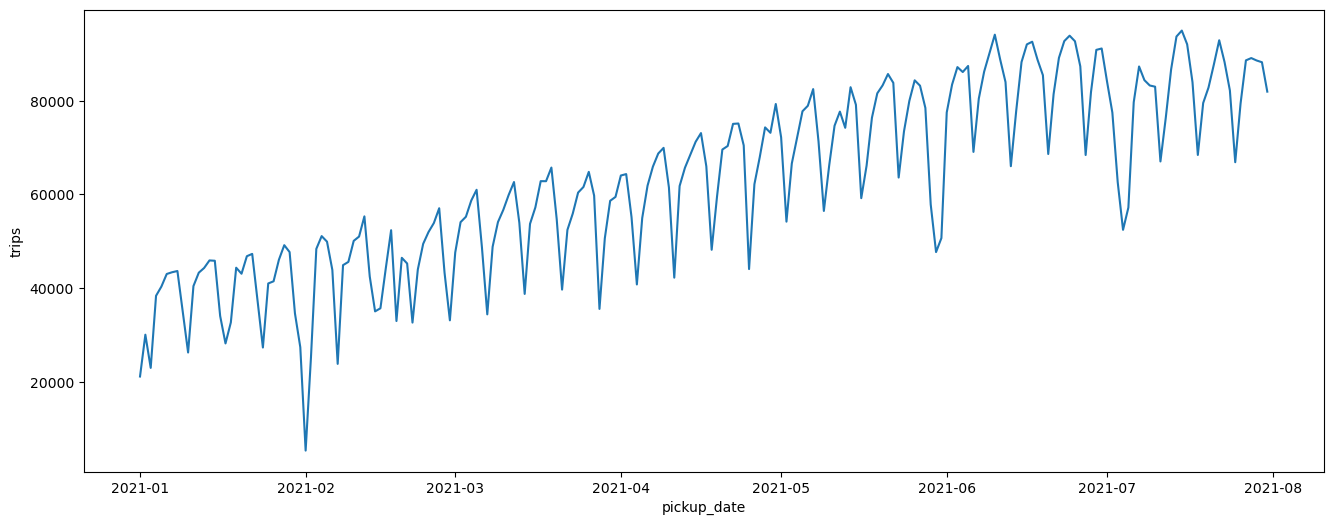

In [134]:
plt.subplots(figsize=(16,6))
sns.lineplot(x='pickup_date',y='trips', data=pd_df)
plt.show()

#### 요일 별 trips의 중간값 확인

In [135]:
# Date_format(c.pickup_date, 'EEEE') -> friday ===> pickup_date의 요일 알아내기
# Date_format(c.pickup_date, 'EEE') -> fri
query="""
select c.pickup_date,
        date_format(c.pickup_date, 'EEEE') as day_of_week, count(*) as trips 
from cleaned c
group by c.pickup_date, day_of_week
"""

pd_df2= spark.sql(query).toPandas()
pd_df2

,pickup_date,day_of_week,trips
0,2021-01-11,Monday,40413
1,2021-01-21,Thursday,46796
2,2021-01-20,Wednesday,43052
3,2021-01-09,Saturday,34968
4,2021-01-02,Saturday,30029
...,...,...,...
207,2021-01-28,Thursday,49151
208,2021-02-25,Thursday,53880
209,2021-02-24,Wednesday,51956
210,2021-01-25,Monday,40972


####  알파벳 순이라 Friday부터 시작 -> 일월화수목금으로 정렬하려면 어떻게 해야할까???

In [136]:
# 알파벳 순이라 Friday부터 시작 -> 
data=pd_df2.groupby('day_of_week')['trips'].median().to_frame().reset_index()
data

,day_of_week,trips
0,Friday,73094.0
1,Monday,56066.5
2,Saturday,61471.0
3,Sunday,43131.5
4,Thursday,72194.5
5,Tuesday,66822.0
6,Wednesday,69399.0


#### 숫자를 강제로 기입하여 순서를 변경하자!!

In [137]:
# 요일 정렬(일~토)
data['sort_dow']=data["day_of_week"].replace({
    "Sunday":0,
    "Monday":1,
    "Tuesday":2,
    "Wednesday":3,
    'Thursday':4,
    "Friday":5,
    "Saturday":6,
})

In [138]:
data=data.sort_values(by='sort_dow')
data

,day_of_week,trips,sort_dow
3,Sunday,43131.5,0
1,Monday,56066.5,1
5,Tuesday,66822.0,2
6,Wednesday,69399.0,3
4,Thursday,72194.5,4
0,Friday,73094.0,5
2,Saturday,61471.0,6


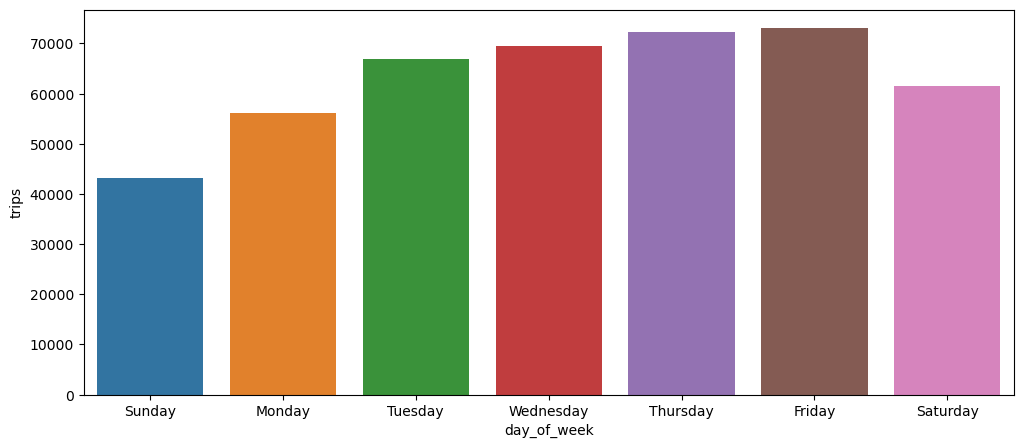

In [139]:
plt.figure(figsize=(12,5))
sns.barplot(
    x='day_of_week',
    y='trips',
    data=data
)
plt.show()

##### 응용 : UDF(내가 만든 함수 활용하기)

In [140]:
def get_weekday(date):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday",get_weekday)

<function __main__.get_weekday(date)>

In [141]:
# 요일변경 UDF함수 만들기 전 쿼리
query="""
select c.pickup_date,
        date_format(c.pickup_date, 'EEEE') as day_of_week, count(*) as trips 
from cleaned c
group by c.pickup_date, day_of_week
"""

pd_df2= spark.sql(query).toPandas()
pd_df2.head()

,pickup_date,day_of_week,trips
0,2021-01-11,Monday,40413
1,2021-01-21,Thursday,46796
2,2021-01-20,Wednesday,43052
3,2021-01-09,Saturday,34968
4,2021-01-02,Saturday,30029


In [142]:
# 요일변경 UDF함수 만들고 난 후 쿼리수정
query="""
select c.pickup_date,
        get_weekday(c.pickup_date) as day_of_week,
        count(*) as trips 
from cleaned c
group by c.pickup_date, day_of_week
"""
pd_df3=spark.sql(query).toPandas()
pd_df3.head()

,pickup_date,day_of_week,trips
0,2021-01-11,Monday,40413
1,2021-01-21,Thursday,46796
2,2021-01-20,Wednesday,43052
3,2021-01-09,Saturday,34968
4,2021-01-02,Saturday,30029


#### 결제 유형 별(payment_type) 분석하기

In [143]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

In [144]:
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

In [145]:
spark.udf.register("parse_payment_type",parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [146]:
query="""
select parse_payment_type(c.payment_type),
        count(*) as trips,
        mean(c.fare_amount) as mean_fare_amount,
        std(c.fare_amount) as std_fare_amount
from cleaned c
group by c.payment_type
"""
spark.sql(query).show(5)

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10118303|12.218953262222634|10.838864815920537|
|                       No Charge|   58553|11.930844534011921| 15.03777118152262|
|                         Dispute|   23537|12.682116667374773|14.832463920441809|
|                            Cash| 3097313|  11.9871481248424|11.698050602195222|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+



In [147]:
spark.stop()